### Classification Model to Predict BTC move

there are many traders who are intertsed in trading contratcs based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

### Imports

In [1]:
# Data Source and Preprocessing
from DataStrat import DataPrecessor

# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Machine Learning
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

# Reporting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
from xgboost import plot_tree

### Data Extraction and Returns Overview

In [2]:
# Extract Data
start_date = "2017-01-01"
end_date = "2022-12-31"
symbol = "BTC-USD"
strat_mgr = DataPrecessor(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

[*********************100%***********************]  1 of 1 completed
Sense check:  14.41 nan


,Open,High,Low,Close,Volume,DOW,Returns,Roll_Rets,Range,Avg_Range,...,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,MA_12,MA_21,Signal,Strat_C_Rets
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-21,1079.280029,1117.250000,1076.930054,1115.300049,186868992,1,0.032704,0.194532,0.037440,0.026809,...,0.030643,0.037247,1.083785,-0.006212,0.012794,0.969563,1030.516418,1029.720142,1.0,0.032704
2017-02-22,1114.800049,1125.390015,1100.550049,1117.439941,136100000,2,0.001919,0.200410,0.022571,0.027142,...,0.032704,0.037440,1.067783,0.030643,0.037247,1.083785,1041.246913,1035.835234,1.0,0.034686
2017-02-23,1117.270020,1176.619995,1116.959961,1166.719971,189454000,3,0.044101,0.275265,0.053413,0.027733,...,0.001919,0.022571,1.003526,0.032704,0.037440,1.067783,1054.769409,1043.212376,1.0,0.080316
2017-02-24,1172.709961,1200.390015,1131.959961,1173.680054,330759008,4,0.005966,0.271311,0.060453,0.029315,...,0.044101,0.053413,1.070432,0.001919,0.022571,1.003526,1069.310994,1050.058568,1.0,0.086761
2017-02-25,1170.410034,1174.849976,1124.589966,1143.839966,139960992,5,-0.025424,0.228090,0.044692,0.030173,...,0.005966,0.060453,1.007941,0.044101,0.053413,1.070432,1082.077489,1054.865231,1.0,0.059131


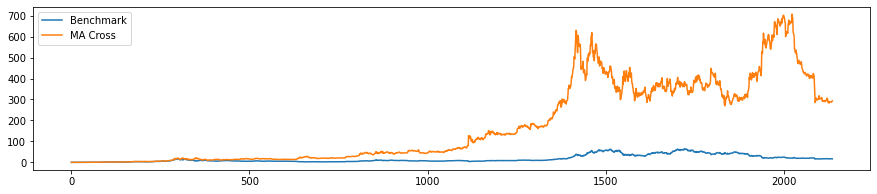

In [3]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values, label="Benchmark")
plt.plot(df["Strat_C_Rets"].values, label="MA Cross")
plt.legend()
plt.show()

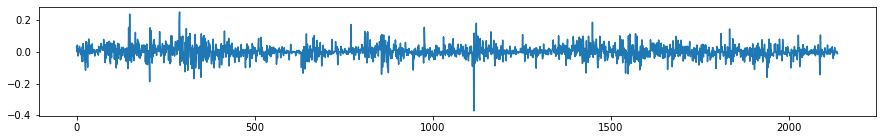

In [4]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

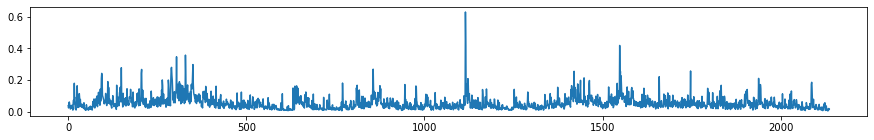

In [5]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Scaling

In [6]:
# Correct for Stationarity
df_fs = df.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,DOW,Returns,Roll_Rets,Range,Avg_Range,...,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,MA_12,MA_21,Signal,Strat_C_Rets
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-21,NaN,NaN,NaN,1115.300049,NaN,1,0.032704,0.194532,0.037440,0.026809,...,0.030643,0.037247,1.083785,-0.006212,0.012794,0.969563,1030.516418,1029.720142,1.0,0.032704
2017-02-22,0.032911,0.007286,0.021933,1117.439941,-0.271682,2,0.001919,0.200410,0.022571,0.027142,...,0.032704,0.037440,1.067783,0.030643,0.037247,1.083785,1041.246913,1035.835234,1.0,0.034686
2017-02-23,0.002216,0.045522,0.014911,1166.719971,0.392021,3,0.044101,0.275265,0.053413,0.027733,...,0.001919,0.022571,1.003526,0.032704,0.037440,1.067783,1054.769409,1043.212376,1.0,0.080316
2017-02-24,0.049621,0.020202,0.013429,1173.680054,0.745854,4,0.005966,0.271311,0.060453,0.029315,...,0.044101,0.053413,1.070432,0.001919,0.022571,1.003526,1069.310994,1050.058568,1.0,0.086761
2017-02-25,-0.001961,-0.021276,-0.006511,1143.839966,-0.576849,5,-0.025424,0.228090,0.044692,0.030173,...,0.005966,0.060453,1.007941,0.044101,0.053413,1.070432,1082.077489,1054.865231,1.0,0.059131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-24,-0.001941,-0.002397,-0.000055,16847.755859,-0.364312,5,0.003025,0.018786,0.004238,0.020153,...,-0.001984,0.006595,0.989677,0.000762,0.016530,1.004287,16983.413086,17030.946801,-1.0,288.445159
2022-12-25,0.003008,-0.000246,-0.002279,16841.986328,0.196184,6,-0.000342,0.023420,0.006285,0.019926,...,0.003025,0.004238,1.019413,-0.001984,0.006595,0.989677,16905.135417,17017.208705,-1.0,288.544314
2022-12-26,-0.000312,0.003533,0.003409,16919.804688,0.019781,0,0.004620,0.031524,0.006409,0.019630,...,-0.000342,0.006285,0.997970,0.003025,0.004238,1.019413,16830.481608,17014.588635,-1.0,287.212628


### Assess Data for ML Readiness

In [7]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [8]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [9]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2136 entries, 2017-02-22 to 2022-12-28
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2136 non-null   float64
 1   High          2136 non-null   float64
 2   Low           2136 non-null   float64
 3   Close         2136 non-null   float64
 4   Volume        2136 non-null   float64
 5   DOW           2136 non-null   int64  
 6   Returns       2136 non-null   float64
 7   Roll_Rets     2136 non-null   float64
 8   Range         2136 non-null   float64
 9   Avg_Range     2136 non-null   float64
 10  RSI           2136 non-null   float64
 11  RSI_Ret       2136 non-null   float64
 12  Bench_C_Rets  2136 non-null   float64
 13  Returns_T1    2136 non-null   float64
 14  Range_T1      2136 non-null   float64
 15  RSI_Ret_T1    2136 non-null   float64
 16  Returns_T2    2136 non-null   float64
 17  Range_T2      2136 non-null   float64
 18  RSI_Ret_T2

In [10]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,DOW,Returns,Roll_Rets,Range,Avg_Range,...,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,MA_12,MA_21,Signal,Strat_C_Rets
count,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,...,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000
mean,0.002117,0.001892,0.002136,18024.734153,0.033808,2.999532,0.002098,0.064924,0.053447,0.053524,...,0.002118,0.053457,1.005136,0.002138,0.053465,1.005210,17984.264992,17950.679029,0.097378,177.777311
std,0.040704,0.035509,0.040941,16748.574436,0.286411,2.000117,0.040702,0.249302,0.044639,0.024212,...,0.040707,0.044633,0.105748,0.040710,0.044629,0.105748,16717.249634,16691.974231,0.995480,190.547164
min,-0.365924,-0.263712,-0.364062,937.520020,-0.869188,0.000000,-0.371695,-0.844981,0.004238,0.015818,...,-0.371695,0.004238,0.453659,-0.371695,0.004238,0.453659,1023.580999,1035.835234,-1.000000,0.034019
25%,-0.015651,-0.012592,-0.012503,6554.615112,-0.126936,1.000000,-0.015811,-0.096476,0.025812,0.036517,...,-0.015811,0.025832,0.952769,-0.015811,0.025861,0.952908,6547.024404,6553.141090,-1.000000,16.393115
50%,0.001493,-0.000237,0.002806,9830.507812,-0.009611,3.000000,0.001692,0.035736,0.041937,0.048231,...,0.001726,0.041937,1.004652,0.001759,0.041937,1.004836,9908.152100,9754.386033,1.000000,60.194739
75%,0.019997,0.015209,0.018797,25066.666992,0.145615,5.000000,0.019712,0.224145,0.065330,0.065098,...,0.019787,0.065330,1.047251,0.019913,0.065330,1.047635,25316.362956,25611.655901,1.000000,341.615846
max,0.250461,0.245708,0.247892,67566.828125,5.439003,6.000000,0.252472,1.154731,0.631387,0.138628,...,0.252472,0.631387,1.926078,0.252472,0.631387,1.926078,64130.533529,63016.876488,1.000000,707.269808


### Add Prediction Target

In [11]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [12]:
# Check for NaNs
nan_location = np.where(np.isnan(df))
nan_location

(array([2136]), array([23]))

In [13]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,DOW,Returns,Roll_Rets,Range,Avg_Range,...,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,MA_12,MA_21,Signal,Strat_C_Rets,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-12-24,16796.976562,16864.703125,16793.527344,16847.755859,9744636213,5,0.003025,0.018786,0.004238,0.020153,...,0.006595,0.989677,0.000762,0.016530,1.004287,16983.413086,17030.946801,-1.0,288.445159,0.0
2022-12-25,16847.505859,16860.554688,16755.253906,16841.986328,11656379938,6,-0.000342,0.023420,0.006285,0.019926,...,0.004238,1.019413,-0.001984,0.006595,0.989677,16905.135417,17017.208705,-1.0,288.544314,0.0
2022-12-26,16842.250000,16920.123047,16812.369141,16919.804688,11886957804,0,0.004620,0.031524,0.006409,0.019630,...,0.006285,0.997970,0.003025,0.004238,1.019413,16830.481608,17014.588635,-1.0,287.212628,0.0
2022-12-27,16919.291016,16959.845703,16642.072266,16717.173828,15748580239,1,-0.011976,0.020742,0.019095,0.019948,...,0.006409,1.032373,-0.000342,0.006285,0.997970,16776.507324,16996.858631,-1.0,290.706088,0.0
2022-12-28,16716.400391,16768.169922,16497.556641,16552.572266,17005713920,2,-0.009846,0.024718,0.016403,0.019605,...,0.019095,0.925648,0.004620,0.006409,1.032373,16768.597982,16982.784598,-1.0,293.606862,0.0


### Train Test Split

In [14]:
# Split into X and Y Data
X = df.iloc[:, : -1]
y = df.iloc[:, -1]

In [15]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (1495, 23)
Shape of y_train:  (1495,)
Shape of X_test:  (642, 23)
Shape of y_test:  (642,)
Size Matches:  True


### Hyperparameters Tuning

In [16]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [17]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [18]:
# Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.001, 0.1, 0.2, 0.5, 1, 1.5, 3, 6, 12, 20],
    "learning_rate": [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12, 15],
    "n_estimators": [25, 50, 80, 100, 115, 200, 300]
}

# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring, random_state=0)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended Params >> ne: 100, lr: 0.01 md: 3 gm: 3


### Model Training

In [19]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [20]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Initial Model Performance Evaluation (Quick Overview)

In [21]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# Training Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

# Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
print("Std Deviation K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("")
print("Just for reference. Right now, we are only focussed on getting some initial features.")
print("If the results look too good to be true, they probably are.")

Training Preds: 
 [0 1 1 1 0]
Average Accuracy K-Fold:  0.65
Std Deviation K-Fold:  0.04
Precision Score 0:  0.726
Precision Score 1:  0.769

Just for reference. Right now, we are only focussed on getting some initial features.
If the results look too good to be true, they probably are.


### Dimensionality reduction - Feature Selection

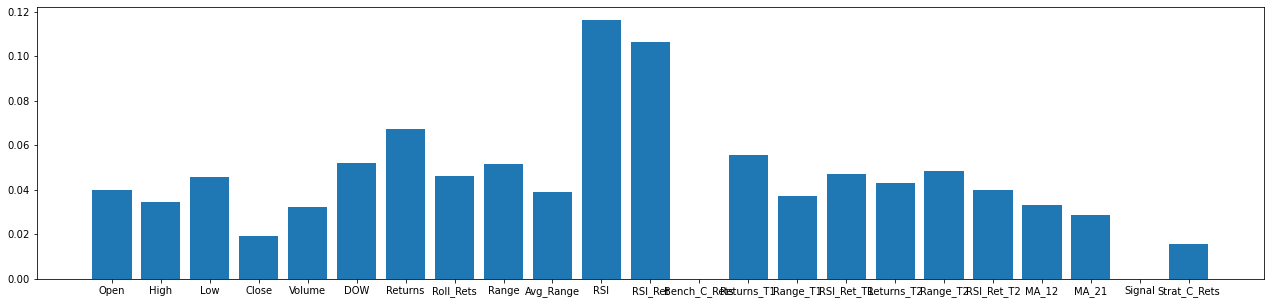

In [22]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

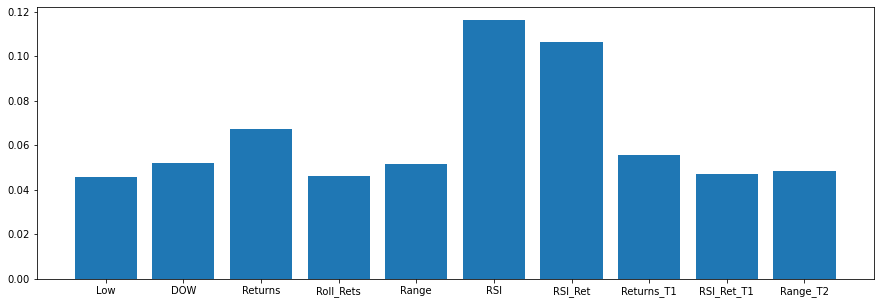

In [23]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

# Plot Recommended Features
fig = plt.figure(figsize=(15, 5))
plt.bar(recommended_feature_labels, recommended_feature_score)
plt.show()

### New Model Training

In [31]:
# Feature Selection
df_f = df.copy()

X = df[recommended_feature_labels]
y = df["TARGET"]


# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [32]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [33]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.fit(X_train, y_train, eval_metric=eval_metric_list, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=3, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Evaluation

In [34]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0 1 1 1 0 0 1 1 1 1]
Preds Probabilities Training Data: 
 [[0.55610573 0.4438943 ]
 [0.4738134  0.5261866 ]
 [0.35768098 0.642319  ]]


In [35]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.65388167 0.34611836]
 [0.6249351  0.3750649 ]
 [0.65224564 0.34775433]]


In [36]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

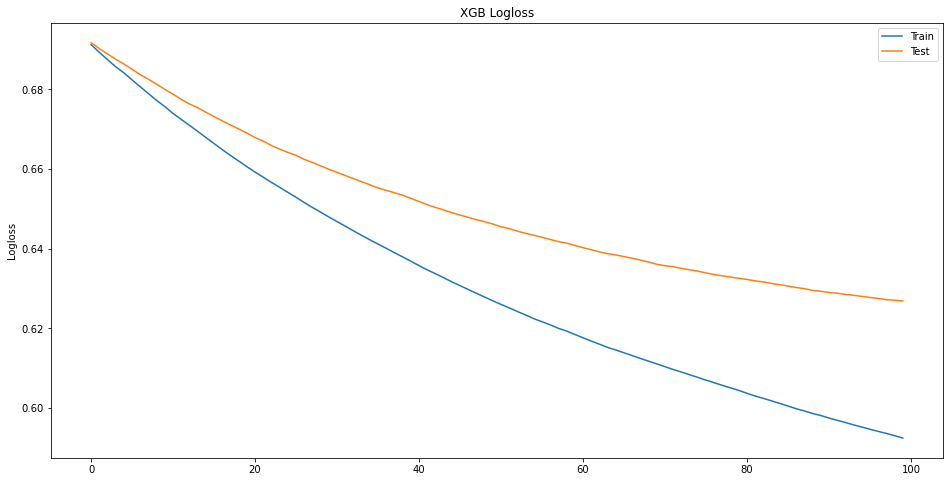

In [37]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)


# Plot Log Loss
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

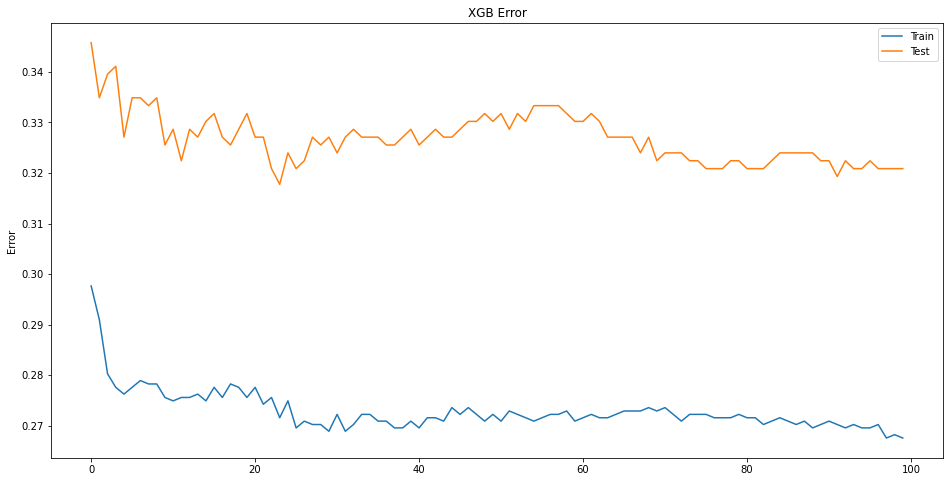

In [38]:
# Plot Classification Error
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

In [39]:
print('Train score:',classifier.score(X_train,y_train))
print('Test score:',classifier.score(X_test,y_test))
# Show summary report - Training
print(classification_report(y_train, classifier.predict(X_train)))
print(classification_report(y_test, classifier.predict(X_test)))

# Scoring of test data
accuracy = accuracy_score(y_test,classifier.predict(X_test))
precision = precision_score(y_test,classifier.predict(X_test))
recall = recall_score(y_test,classifier.predict(X_test))


Train score: 0.7324414715719063
Test score: 0.6791277258566978
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.81       939
         1.0       0.76      0.41      0.53       556

    accuracy                           0.73      1495
   macro avg       0.74      0.67      0.67      1495
weighted avg       0.74      0.73      0.71      1495

              precision    recall  f1-score   support

         0.0       0.68      0.95      0.80       422
         1.0       0.62      0.16      0.25       220

    accuracy                           0.68       642
   macro avg       0.65      0.55      0.52       642
weighted avg       0.66      0.68      0.61       642



[[868  71]
 [329 227]]


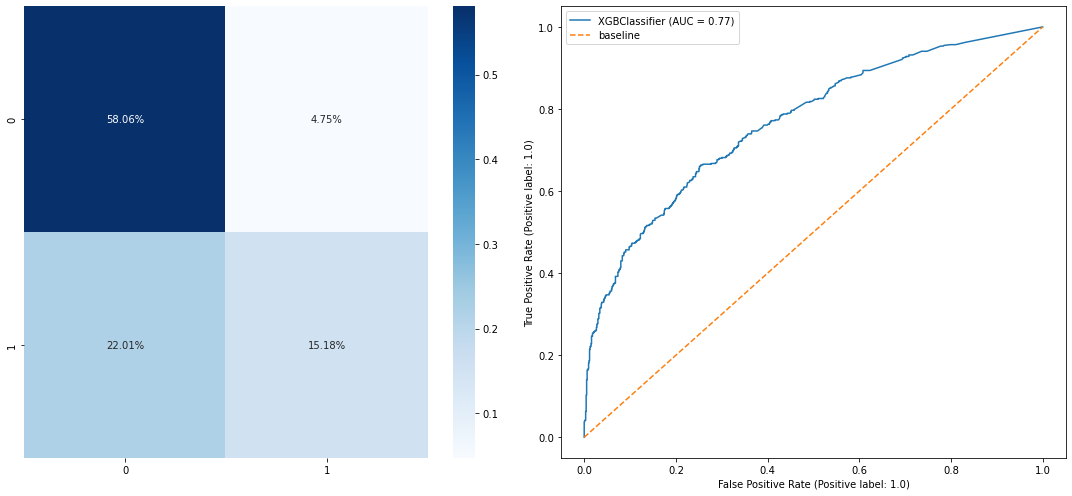

In [40]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

#ax0.set_ylabel("Probability")
#ax0.set_xlabel("Target")
#ax0.text(s="Target distribution", x=1.2e5, y=9.8e-6, fontsize=12)

ys1 = classifier.predict(X_train)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_train, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(classifier, X_train, y_train, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

[[401  21]
 [185  35]]


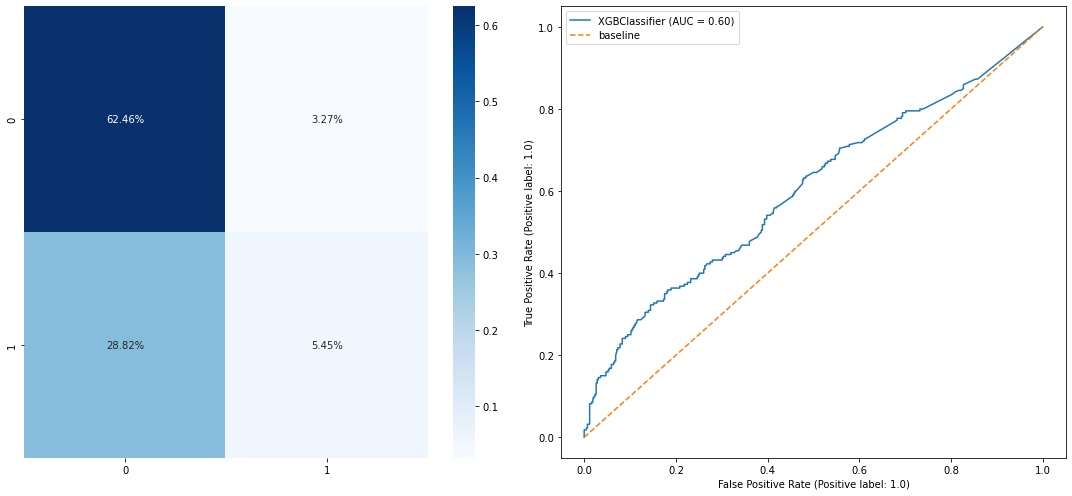

In [41]:
f, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 7))

ys1 = classifier.predict(X_test)
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, ys1)
print(cf_matrix)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues',ax=ax0)

plot_roc_curve(classifier, X_test, y_test, ax=ax1)
ax1.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
ax1.legend()

f.tight_layout()

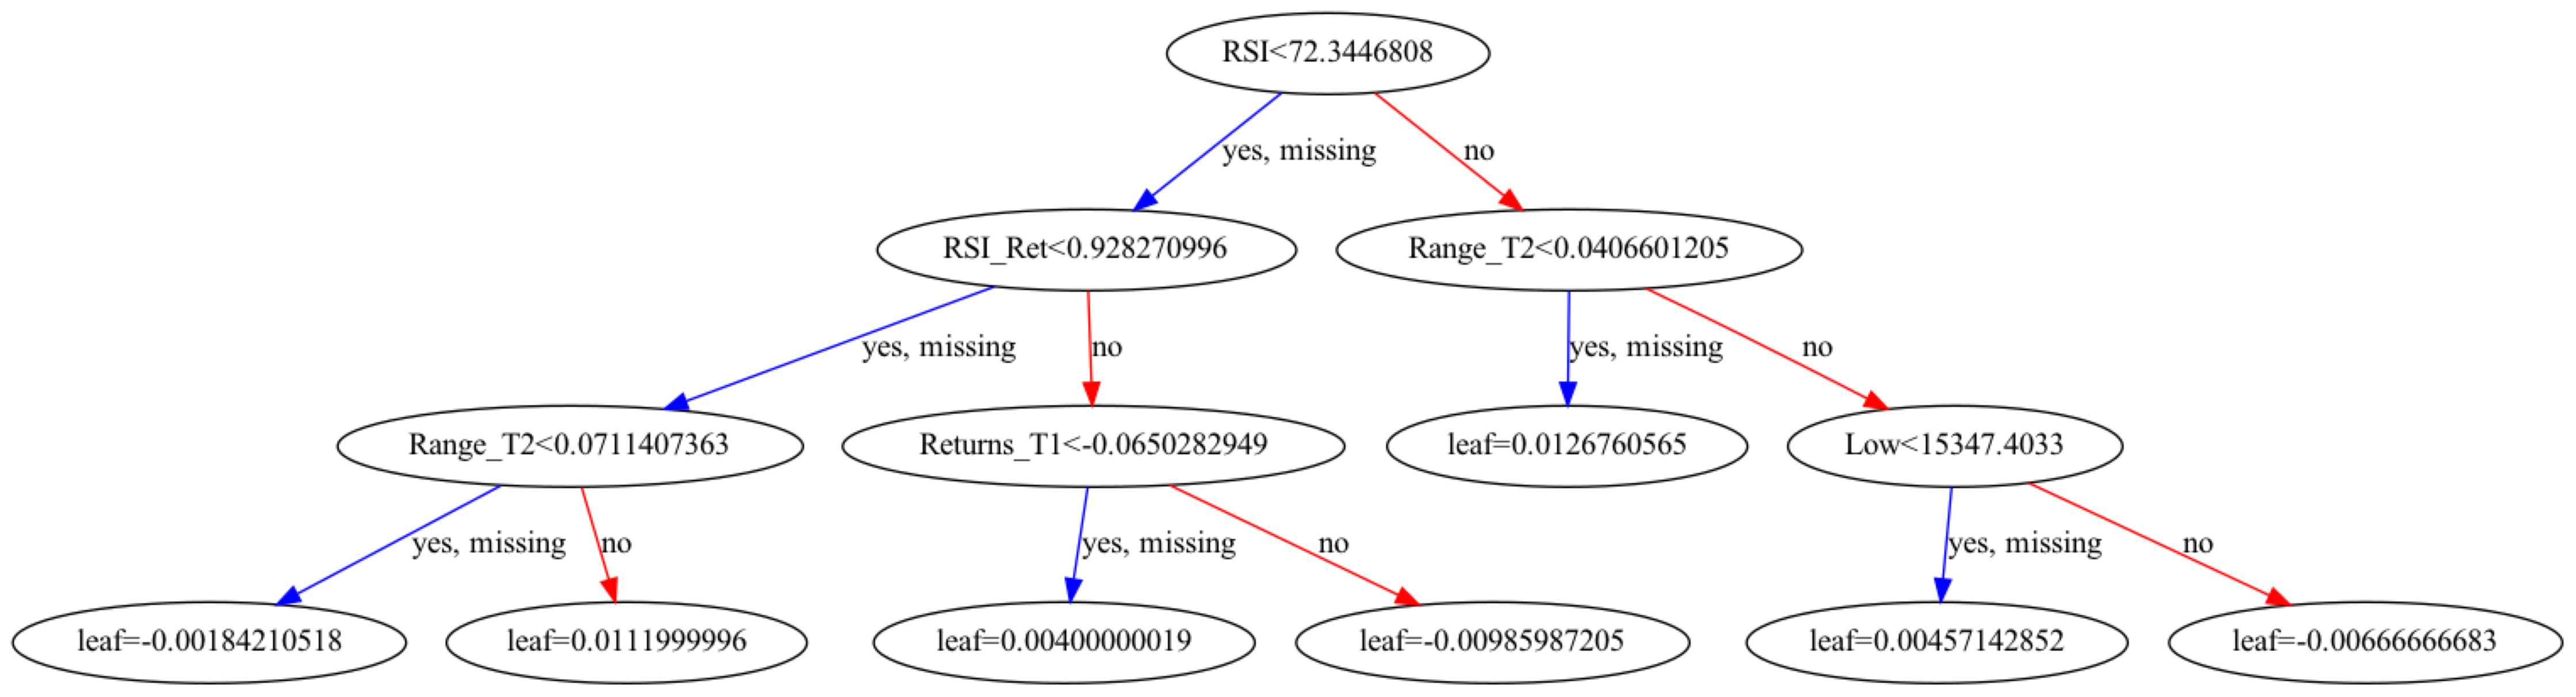

In [42]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)